# 2D Example

This notebook can be used to reproduce the results from the Examples 3.7, 3.8, 3.11 and 3.12.

We consider the system 
$$
A =
\left[
\begin{array}{cc}
-1 & 4 \\
-2 & -1 \\
\end{array}
\right], \quad
B =
\left[
\begin{array}{cc}
1\\
2\\
\end{array}
\right], \quad
C =
\left[
\begin{array}{cc}
1 & 0\\
\end{array}\right], \quad
D = 0.
$$


In [19]:
using DrWatson
@quickactivate "klap"

Pkg.status()

Status `~/Development/klap/Project.toml`
  [aaaaaaaa] ControlSystemsBase v1.11.3
  [a93c6f00] DataFrames v1.7.0
  [e30172f5] Documenter v1.8.0
  [634d3b9d] DrWatson v2.18.0
  [26cc04aa] FiniteDifferences v0.12.32
  [4076af6c] JuMP v1.23.6
  [b964fa9f] LaTeXStrings v1.4.0
  [99c1a7ee] MatrixEquations v2.4.2
  [429524aa] Optim v1.10.0
  [222273ac] Passivation v1.0.0 `src/Passivation`
  [91a5bcdd] Plots v1.40.9
  [21fd56a4] RobustAndOptimalControl v0.4.34
  [37e2e46d] LinearAlgebra v1.11.0


In [20]:
using LinearAlgebra, ControlSystemsBase, Plots, LaTeXStrings
using Passivation

import Passivation: ispassive

We construct the system via the [`ControlSystems.jl`](https://github.com/JuliaControl/ControlSystems.jl) package.

In [21]:
A = [-1 4; -2 -1];
B = [1; 2];
C = [1 0];

Σ1 = ss(A, B, C, 0)

StateSpace{Continuous, Int64}
A = 
 -1   4
 -2  -1
B = 
 1
 2
C = 
 1  0
D = 
 0

Continuous-time state-space model

The following functions will be used for the visualization of the results.

In [22]:
function lspace(Σ, l1lims, l2lims, N, M=sqrt(Σ.D + Σ.D'), P=gram(Σ, :c))
    l1 = range(l1lims[1], l1lims[2], length=N)
    l2 = range(l2lims[1], l2lims[2], length=N)
    f(l1, l2) = Passivation.J(Σ, [l1; l2;;], M, P)
    J = @. f(l1', l2)
    return l1, l2, J
end;

function cspace(Σ, c1lims, c2lims, N, P=gram(Σ, :c))
    c1 = range(c1lims[1], c1lims[2], length=N)
    c2 = range(c2lims[1], c2lims[2], length=N)
    function f(c1, c2)
        if ispassive(ss(Σ.A, Σ.B, [c1 c2], Σ.D), opt=:popov)
            return Passivation.J(C - [c1 c2], P)
        else
            return NaN
        end
    end
    
    J = @. f(c1', c2)
    return c1, c2, J
end;

function optpaths(Σ, res)
    Lpath = reduce(hcat, [res.trace[i].metadata["x"] for i in 1:length(res.trace)])
    Cpath = reduce(vcat, [Passivation.Cr(Σ, L[:,:]) for L in eachcol(Lpath)])'
    return Lpath, Cpath
end;

With the functions above, we can visualize the $\mathcal{H}_2$-error for values of $L$ and passivating $C$:

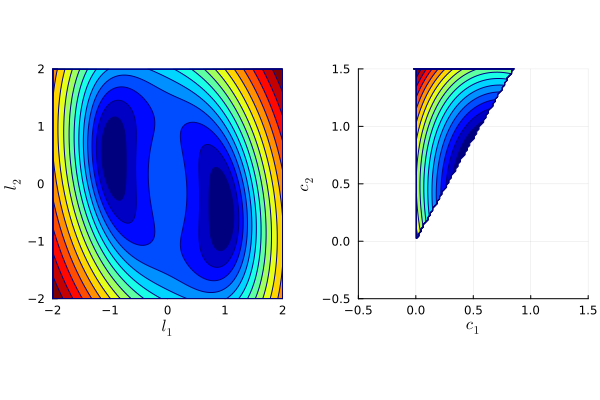

In [23]:
# Mesh sampling
N=100;
l1lims=[-2, 2]; l2lims=[-2, 2];
c1lims=[-0.5, 1.5]; c2lims=[-0.5, 1.5];

l1, l2, JL = lspace(Σ1, l1lims, l2lims, N)
c1, c2, JC = cspace(Σ1, c1lims, c2lims, N)

pL = contourf(l1, l2, log10.(JL), aspect_ratio=:equal, legend = :none, xlims = l1lims, ylims = l2lims, xlabel = L"l_1", ylabel = L"l_2", color = :jet);
pC = contourf(c1, c2, JC, aspect_ratio=:equal, legend = :none, grid=true, xlims = c1lims, ylims = c2lims, xlabel = L"c_1", ylabel = L"c_2", color = :jet);

plot(pL, pC, layout=(1,2))

Applying KLAP to the system with initializing $L_0=[-2, -2]^\top$ yields the following results:

In [24]:
L0 = [-2.0; -2.0;;]
Σp, res = klap(Σ1, L0; store_trace=true, extended_trace=true, verbose=false)

(StateSpace{Continuous, Float64}
A = 
 -1.0   4.0
 -2.0  -1.0
B = 
 1.0
 2.0
C = 
 0.4615384615370124  0.8076923076897717
D = 
 0.0

Continuous-time state-space model,  * Status: success

 * Candidate solution
    Final objective value:     9.423077e-01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 6.31e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 6.56e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.48e-13 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.69e-13 ≤ 1.0e-06
    |g(x)|                 = 1.86e-11 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    10
    f(x) calls:    32
    ∇f(x) calls:   32
)

Visualizing the path taken by the optimizer:

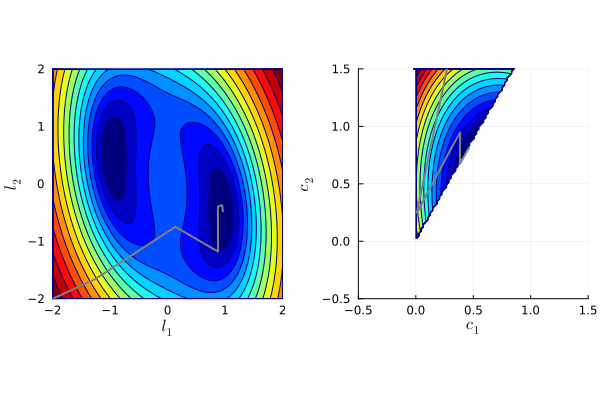

In [25]:
Lpath, Cpath = optpaths(Σ1, res)

plot!(pL, Lpath[1,:], Lpath[2,:], label="path", lw=2, color=:gray)
plot!(pC, Cpath[1,:], Cpath[2,:], label="path", lw=2, color=:gray)

plot(pL, pC, layout=(1,2))

## Adding a feedthrough term

We no add a feedthrough term to the system, i.e., we set $D = \tfrac{1}{8}$.

In [26]:
D = 1//8

Σ2 = ss(A, B, C, D)

StateSpace{Continuous, Rational{Int64}}
A = 
 -1//1   4//1
 -2//1  -1//1
B = 
 1//1
 2//1
C = 
 1//1  0//1
D = 
 1//8

Continuous-time state-space model

We again visualize the $\mathcal{H}_2$-error for values of $L$ and passivating $C$:

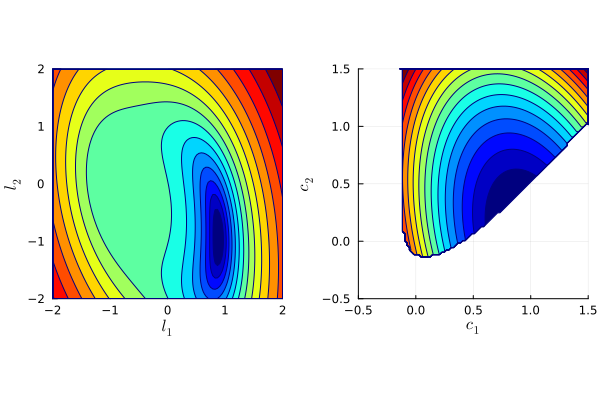

In [27]:
l1, l2, JL = lspace(Σ2, l1lims, l2lims, N)
c1, c2, JC = cspace(Σ2, c1lims, c2lims, N)
pL = contourf(l1, l2, log10.(JL), aspect_ratio=:equal, legend = :none, xlims = l1lims, ylims = l2lims, xlabel = L"l_1", ylabel = L"l_2", color = :jet);
pC = contourf(c1, c2, JC, aspect_ratio=:equal, legend = :none, grid=true, xlims = c1lims, ylims = c2lims, xlabel = L"c_1", ylabel = L"c_2", color = :jet);

plot(pL, pC, layout=(1,2))

And observe, that adding a feedthrough term changes the situation significantly. We now have local minimizers, which are not global minimizers.

Indeed, applying KLAP to the system with initializing $L_0=[-1.5, 1.5]^\top$ yields the following results:

In [28]:
L0 = [-1.5; 1.5;;]
Σp, res = klap(Σ2, L0; store_trace=true, extended_trace=true, restart=false, verbose=false)

(StateSpace{Continuous, Float64}
A = 
 -1.0   4.0
 -2.0  -1.0
B = 
 1.0
 2.0
C = 
 4.674038933671909e-14  1.0000000000001867
D = 
 0.125

Continuous-time state-space model,  * Status: success

 * Candidate solution
    Final objective value:     2.500000e+00

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.08e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.08e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 5.33e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 2.13e-14 ≤ 1.0e-06
    |g(x)|                 = 1.58e-10 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    11
    f(x) calls:    34
    ∇f(x) calls:   34
)

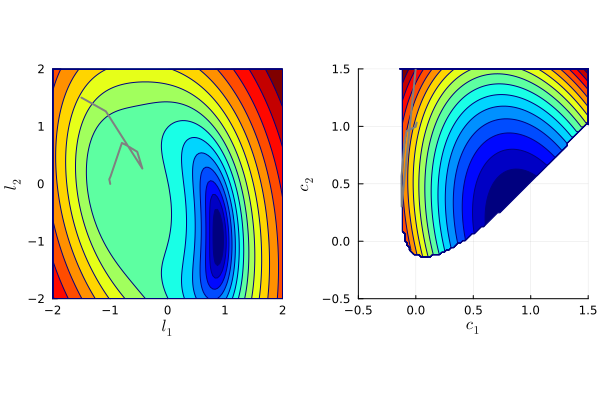

In [29]:
Lpath, Cpath = optpaths(Σ2, res)

plot!(pL, Lpath[1,:], Lpath[2,:], label="path", lw=2, color=:gray)
plot!(pC, Cpath[1,:], Cpath[2,:], label="path", lw=2, color=:gray)

plot(pL, pC, layout=(1,2))

We converge to a local minimizer.

## Restart strategy

However, if we use our restart strategy, we can find the global minimizer:

In [30]:
result = klap(Σ2, L0; store_trace=true, extended_trace=true, verbose=false, restart=true, α=1e-1);
Σp = result[1]

┌ Info: Checking eigvals of Y ...
└ @ Passivation /Users/jonas/Development/klap/src/Passivation/src/klap.jl:44
┌ Info: Possible stuck in local minimum, performing unconstrained gradient step ...
└ @ Passivation /Users/jonas/Development/klap/src/Passivation/src/klap.jl:47
┌ Info: Checking eigvals of Y ...
└ @ Passivation /Users/jonas/Development/klap/src/Passivation/src/klap.jl:44
┌ Info: Global minimum detected, no restart needed.
└ @ Passivation /Users/jonas/Development/klap/src/Passivation/src/klap.jl:60


StateSpace{Continuous, Float64}
A = 
 -1.0   4.0
 -2.0  -1.0
B = 
 1.0
 2.0
C = 
 0.8352431817125443  0.3401324147424071
D = 
 0.125

Continuous-time state-space model

Visualizing the path taken by the optimizer, where the unconstrained gradient step is shown as dashed line:

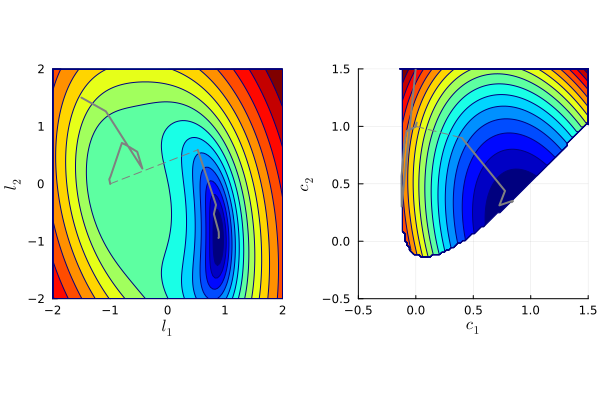

In [31]:
Lpath1, Cpath1 = optpaths(Σ2, result[3])
Lpath2, Cpath2 = optpaths(Σ2, result[2])

pL = contourf(l1, l2, log10.(JL), aspect_ratio=:equal, legend = :none, xlims = l1lims, ylims = l2lims, xlabel = L"l_1", ylabel = L"l_2", color = :jet);
pC = contourf(c1, c2, JC, aspect_ratio=:equal, legend = :none, grid=true, xlims = c1lims, ylims = c2lims, xlabel = L"c_1", ylabel = L"c_2", color = :jet);

plot!(pL, Lpath1[1,:], Lpath1[2,:], lw=2, color=:gray)
plot!(pC, Cpath1[1,:], Cpath1[2,:], lw=2, color=:gray)

# Uncontrained gradient step
plot!(pL, [Lpath1[1,end], Lpath2[1,1]], [Lpath1[2,end], Lpath2[2,1]], seriestype=:path, ls=:dash, color=:gray)
plot!(pC, [Cpath1[1,end], Cpath2[1,1]], [Cpath1[2,end], Cpath2[2,1]], seriestype=:path, ls=:dash, color=:gray)

plot!(pL, Lpath2[1,:], Lpath2[2,:], lw=2, color=:gray)
plot!(pC, Cpath2[1,:], Cpath2[2,:], lw=2, color=:gray)

plot(pL, pC, layout=(1,2))

## Initialization strategy

We can also use the initialization strategy to significantly improve the convergence behavior in this example:

┌ Info: Perturbation ΔD = 0.1704754432451463
└ @ Main /Users/jonas/Development/klap/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X34sZmlsZQ==.jl:9


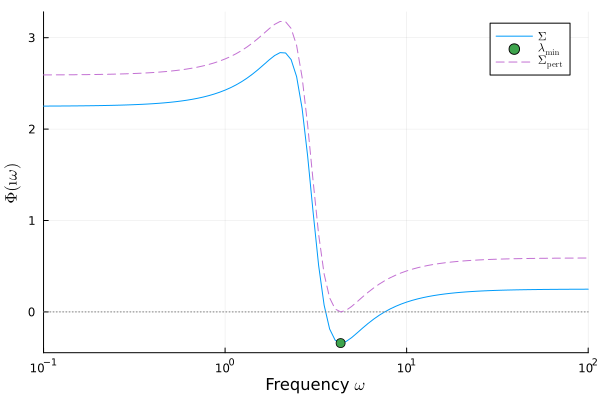

In [32]:
Λmin, ω, _, _, _, _ = sampopov(Σ2; ω=10 .^ range(-1, stop=2, length=100))
p = plot(ω, Λmin, xlims=(1e-1, 1e2), label=L"\Sigma", xaxis=:log, xlabel=L"Frequency $\omega$", ylabel=L"\Phi(\imath \omega)")
hline!(p, [0], color=:gray, linestyle=:dot, label=nothing)

i = argmin(Λmin)
scatter!(p, [ω[i]], [Λmin[i]], label=L"\lambda_{\mathrm{min}}", ms=5, legend=:topright)

ΔD = -minimum(Λmin)/2
@info "Perturbation ΔD = $ΔD"
Σpert = ss(Σ2.A, Σ2.B, Σ2.C, Σ2.D + ΔD * I)

Λmin, _, _, _, _, _ = sampopov(Σpert; ω=10 .^ range(-1, stop=2, length=100))
plot!(p, ω, Λmin, xlims=(1e-1, 1e2), label=L"\Sigma_{\mathrm{pert}}", ls=:dash)

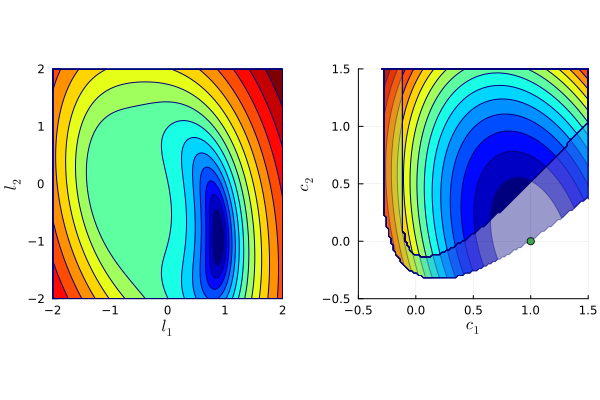

In [33]:
_, _, JCpert = cspace(Σpert, c1lims, c2lims, N)

pL = contourf(l1, l2, log10.(JL), aspect_ratio=:equal, legend = :none, xlims = l1lims, ylims = l2lims, xlabel = L"l_1", ylabel = L"l_2", color = :jet);
pC = contourf(c1, c2, JCpert, alpha = 0.4, aspect_ratio=:equal, legend = :none, grid=true, xlims = c1lims, ylims = c2lims, xlabel = L"c_1", ylabel = L"c_2", color = :jet);
contourf!(pC, c1, c2, JC, color = :jet)
plot!(pC, [Σ2.C[1]], [Σ2.C[2]], seriestype=:scatter)

plot(pL, pC, layout=(1,2))

We perturb the feedthrough matrix to achieve a passive realization. Then we use the perturbed system to obtain an initial guess for KLAP.

In [34]:
L0 = Passivation.L0(Σpert)

Σp, res = klap(Σ2, L0; store_trace=true, extended_trace=true, verbose=false)

(StateSpace{Continuous, Float64}
A = 
 -1.0   4.0
 -2.0  -1.0
B = 
 1.0
 2.0
C = 
 0.8352431817135928  0.34013241474339007
D = 
 0.125

Continuous-time state-space model,  * Status: success

 * Candidate solution
    Final objective value:     1.275129e-01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 3.80e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.03e-07 ≰ 0.0e+00
    |f(x) - f(x')|         = 3.90e-14 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 3.06e-13 ≤ 1.0e-06
    |g(x)|                 = 1.36e-11 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    7
    f(x) calls:    20
    ∇f(x) calls:   20
)

The following plot shows the path taken by the optimizer:

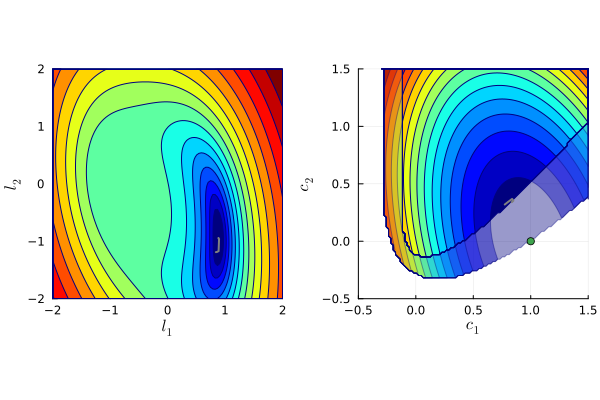

In [35]:
Lpath, Cpath = optpaths(Σ2, res)

plot!(pL, Lpath[1,:], Lpath[2,:], label="path", lw=2, color=:gray)
plot!(pC, Cpath[1,:], Cpath[2,:], label="path", lw=2, color=:gray)

plot(pL, pC, layout=(1,2))